In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class
from src.preprocessing.sequence_classification.set_fit_dataset import SetFitDataset
from src.model.sequence_classification.setfit_trainer import SetFitTrainer
import warnings
warnings.filterwarnings("ignore")

In [3]:
notebook_login()

In [3]:
!mkdir logs
model_name = "SetFit"
dataset_name = "ADE_CORPUS"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
# logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


## SetFit

In [4]:
model = SentenceTransformer("whaleloops/phrase-bert",
                            cache_folder= "/Data/pedro.silva/")

In [5]:
ade_corpus_dataset = load_dataset(
    "ade_corpus_v2", 
    name= "Ade_corpus_v2_classification",
    cache_dir= "/Data/pedro.silva"
)

In [6]:
class_names = ["Not ADE Related", "ADE related"]

In [7]:
num_classes = len(ade_corpus_dataset['train']\
    .features['label']\
    .names)

classes_names = ade_corpus_dataset['train']\
    .features['label']\
    .names

num_classes

2

In [8]:
def stratified_train_test_split(
    dataset : Dataset,
    classes : np.ndarray,
    train_size : float
):
    """Performs train test split keeping class distributions

    Args:
        dataset (Dataset): _description_
        classes (np.ndarray): _description_
        train_size (float): _description_

    Returns:
        _type_: _description_
    """    

    if isinstance(dataset, pd.DataFrame):
        df = dataset

    else:
        df = dataset.to_pandas()
        
    indexes_dict = {}
    for label in classes[0]:
        indexes_dict[label] = df.query(f"label == {label}")


    
    train_data = {
        'label': [],
        'text': []
    }

    validation_data = {
        "label" : [],
        "text": []
    }

    class_proportion = df['label'].value_counts()/len(df)

    # generating train data
    for label in classes[0]:
        n = len(indexes_dict[label])

        if isinstance(train_size, int):
            size = int(class_proportion[label] * train_size)
            
        else:
            size = int(train_size * n)

        train_data['text'] += df.query(f"label == {label}")\
            [0:size]\
            ['text']\
            .to_list()
        
        train_data['label'] += [label]*size
        
        validation_data['text'] +=df.query(f"label == {label}")\
            [size:]\
            ['text']\
            .to_list()
        
        validation_data['label'] += [label]* (n-size)

    return train_data, validation_data

## Few shot learning approach - 50 shots

In [9]:
classes = np.unique(ade_corpus_dataset['train']['label'], return_counts=True)

n_shots = 50

train_validation, test_df = stratified_train_test_split(
    ade_corpus_dataset['train'],
    classes,
    train_size = n_shots
)
train_df, val_df = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    30
)

In [10]:
val_df = pd.DataFrame(val_df).to_dict('list')
test_df = pd.DataFrame(test_df).sample(n = 1000).to_dict('list')

In [11]:
X_train, y_train = get_n_shots_per_class(
    train_df['text'],
    train_df['label'],
    n_shots = min(np.bincount(train_df['label'])),
    num_classes= num_classes
)
X_val, y_val = get_n_shots_per_class(
    val_df['text'], 
    val_df['label'],
    n_shots = min(50,min(np.bincount(val_df['label']))),
    num_classes=num_classes
)

In [12]:
set_fit_data_train = SetFitDataset(
    train_df['text'],
    train_df['label'], 
    input_example_format= True
    # R = 5
)

set_fit_data_val = SetFitDataset(
    val_df['text'], 
    val_df['label'],
    # R = 5,
    input_example_format= False
)

In [13]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=True
)

val_dataloader = DataLoader(
    set_fit_data_val
)

In [14]:
from IPython.display import clear_output

## Training embedding

In [15]:
class CLF(torch.nn.Module):
    def __init__(
        self,
        in_features : int,
        out_features : int, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features, 512)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(512, 256)
        self.layer3 = torch.nn.Linear(256, out_features)

    def forward(self, x : torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        return self.layer3(x)
    

In [83]:
embedding_model = SentenceTransformer(
    "peulsilva/phrase-bert-setfit-300shots-yahoo_answers",
    cache_folder="/Data/pedro.silva/"
).to(device)

in_features = embedding_model.get_sentence_embedding_dimension()

clf = CLF(
    in_features,
    num_classes,
).to(device)



trainer = SetFitTrainer(
    embedding_model,
    clf,
    dataset_name,
    "phrase-bert",
    num_classes
)

In [84]:
trainer.train_embedding(
    train_dataloader,
    val_dataloader,
    n_shots,
    n_epochs=30,
    save = False
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/406 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
trainer.best_model.save_to_hub(f"peulsilva/{trainer.model_name}-setfit-{n_shots}shots-{trainer.dataset_name}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Cloning https://huggingface.

Upload file model.safetensors:   0%|          | 1.00/418M [00:00<?, ?B/s]

To https://huggingface.co/peulsilva/phrase-bert-setfit-50shots-ADE_CORPUS
   fae5a3f..aeb7934  main -> main

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/peulsilva/phrase-bert-setfit-50shots-ADE_CORPUS/commit/aeb793429a4447acd3b68f41919dfccc772d2b57'

### Training classifier 

In [85]:
from random import shuffle
def shuffle_two_lists(X, y ):
    X_shuff = []
    y_shuff = []
    index_shuf = list(range(len(X)))
    shuffle(index_shuf)
    for i in index_shuf:
        X_shuff.append(X[i])
        y_shuff.append(y[i])


    return X_shuff, y_shuff


In [86]:
from src.utils import FocalLoss

In [87]:
_, class_counts = np.unique(
    train_df['label'],
    return_counts=True,
)

alpha = len(train_df['label'])/class_counts

In [88]:
embedding_model = SentenceTransformer(
    f"peulsilva/phrase-bert-setfit-{n_shots}shots-{dataset_name}",
    cache_folder='/Data/pedro.silva/'
).to(device)

# embedding_model = trainer.best_model

X_train_shuffled , y_train_shuffled = shuffle_two_lists(
    train_df['text'], 
    train_df['label']
)

history, embedding_model, clf = trainer.train_classifier(
    X_train_shuffled,
    y_train_shuffled,
    val_df['text'],
    val_df['label'],
    loss_fn= FocalLoss(alpha,2),
    clf = CLF(in_features, num_classes),
    embedding_model=embedding_model,
    n_epochs=15,
    lr = 1e-3
)

---------Epoch: 14-----------
f1 score: 0.444444477558136
tensor([[13,  1],
        [ 4,  2]], device='cuda:0')


In [89]:
best_epoch = 0
best_f1 = np.max(history)
for idx, f1 in enumerate(history):
    if f1 == best_f1.item():
        best_epoch = idx

In [90]:
best_epoch

4

Text(0.5, 1.0, 'SetFit training results- AG news - 5 shots')

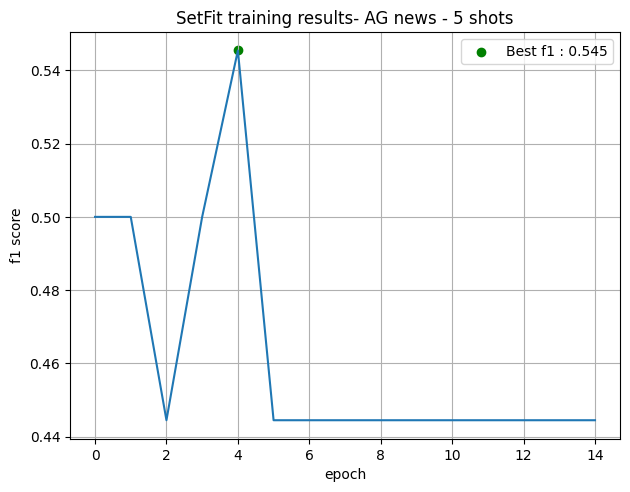

In [91]:
# history = ([k.to('cpu').numpy() for k in history])
plt.plot(history)
plt.scatter(
    [best_epoch], 
    best_f1.item(),
    color = "green",
    label = f"Best f1 : {round(best_f1.item(),3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title("SetFit training results- AG news - 5 shots")

## Inference

In [92]:
y_true_val = torch.tensor([],device=device)
y_pred_val = torch.tensor([],device=device)


for i in tqdm(range(len(test_df['label']))):
    text = test_df['text'][i]
    label = torch.tensor(test_df['label'][i])\
        .to(device)

    with torch.no_grad():
        embedding = embedding_model.encode(text, convert_to_tensor=True)

        y_pred = trainer.best_clf(embedding)\
            .argmax()
        
        y_pred_val = torch.cat([
            y_pred_val, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_val = torch.cat([
            y_true_val, 
            torch.tensor([test_df['label'][i]]).to(device)
        ])
        
f1 = binary_f1_score(
    y_pred_val,
    y_true_val,
    # num_classes=num_classes
)



  1%|          | 11/1000 [00:00<00:09, 108.18it/s]

100%|██████████| 1000/1000 [00:08<00:00, 117.73it/s]


In [93]:
conf_matrix = multiclass_confusion_matrix(
    y_pred_val.to(torch.int64),
    y_true_val.to(torch.int64),
    num_classes
)

In [94]:
f1

tensor(0.3014, device='cuda:0')

In [58]:
conf_matrix

tensor([[633,  94],
        [211,  62]], device='cuda:0')

Text(0.5, 1.0, 'Confusion Matrix ADE_CORPUS - SetFit - 50 shots')

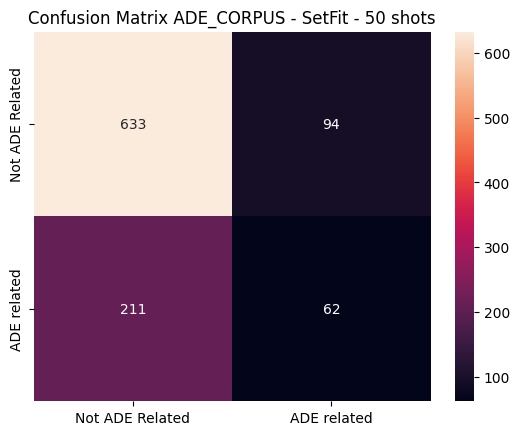

In [59]:
df = pd.DataFrame(
    conf_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - SetFit - {n_shots} shots")

## General study 

In [10]:
classes = np.unique(ade_corpus_dataset['train']['label'], return_counts=True)

n_shots = 500

train_validation, test_df = stratified_train_test_split(
    ade_corpus_dataset['train'],
    classes,
    train_size = n_shots
)
train_df, val_df = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    300
)

In [11]:
val_df = pd.DataFrame(val_df).to_dict('list')
test_df = pd.DataFrame(test_df).sample(n = 1000).to_dict('list')

In [12]:
X_train, y_train = get_n_shots_per_class(
    train_df['text'],
    train_df['label'], 
    n_shots = min(50,min(np.bincount(train_df['label']))),
    num_classes= num_classes
)
X_val, y_val = get_n_shots_per_class(
    val_df['text'], 
    val_df['label'],
    n_shots = min(25,min(np.bincount(val_df['label']))),
    num_classes=num_classes
)

In [13]:
set_fit_data_train = SetFitDataset(
    X_train, 
    y_train,
    input_example_format= True,
)

set_fit_data_val = SetFitDataset(
    X_val, 
    y_val,
    input_example_format= False
)

In [14]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=True
)

val_dataloader = DataLoader(
    set_fit_data_val
)

In [15]:
from IPython.display import clear_output

## Training embedding

In [16]:
class CLF(torch.nn.Module):
    def __init__(
        self,
        in_features : int,
        out_features : int, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features, 512)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(512, 256)
        self.layer3 = torch.nn.Linear(256, out_features)

    def forward(self, x : torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        return self.layer3(x)
    

In [17]:
embedding_model = SentenceTransformer(
    "whaleloops/phrase-bert",
    cache_folder="/Data/pedro.silva/"
).to(device)

in_features = embedding_model.get_sentence_embedding_dimension()

clf = CLF(
    in_features,
    num_classes,
).to(device)



trainer = SetFitTrainer(
    embedding_model,
    clf,
    dataset_name,
    "phrase-bert",
    num_classes
)

In [31]:
trainer.train_embedding(
    train_dataloader,
    val_dataloader,
    n_shots,
    n_epochs=5,
    save = False
)

f1 score: 0.5515660643577576
metric: 0.5104166429029228
tensor([[277, 348],
        [239, 361]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4950 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 23.66 GiB total capacity; 3.06 GiB already allocated; 5.31 MiB free; 3.33 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [138]:
trainer.best_model.save_to_hub(f"peulsilva/{trainer.model_name}-setfit-{n_shots}shots-{trainer.dataset_name}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Cloning https://huggingface.

Upload file model.safetensors:   0%|          | 1.00/418M [00:00<?, ?B/s]

To https://huggingface.co/peulsilva/phrase-bert-setfit-500shots-ADE_CORPUS
   a38a174..d85037f  main -> main

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/peulsilva/phrase-bert-setfit-500shots-ADE_CORPUS/commit/d85037f4e65e8881f72046bf4a2d2a547cbd6e63'

### Training classifier 

In [18]:
from random import shuffle
def shuffle_two_lists(X, y ):
    X_shuff = []
    y_shuff = []
    index_shuf = list(range(len(X)))
    shuffle(index_shuf)
    for i in index_shuf:
        X_shuff.append(X[i])
        y_shuff.append(y[i])


    return X_shuff, y_shuff


In [19]:
from src.utils import FocalLoss

In [20]:
_, class_counts = np.unique(
    train_df['label'],
    return_counts=True,
)

alpha = len(train_df['label'])/class_counts

In [22]:
embedding_model = SentenceTransformer(
    f"peulsilva/phrase-bert-setfit-{n_shots}shots-{dataset_name}",
    cache_folder='/Data/pedro.silva/'
).to(device)

# embedding_model = trainer.best_model

X_train_shuffled , y_train_shuffled = shuffle_two_lists(
    train_df['text'], 
    train_df['label']
)

history, embedding_model, clf = trainer.train_classifier(
    X_train_shuffled,
    y_train_shuffled,
    val_df['text'],
    val_df['label'],
    loss_fn= FocalLoss(alpha,1),
    clf = CLF(in_features, num_classes),
    embedding_model=embedding_model,
    n_epochs=100,
    lr = 1e-4
)

---------Epoch: 99-----------
f1 score: 0.30000001192092896
tensor([[132,  10],
        [ 46,  12]], device='cuda:0')


In [139]:
best_epoch = 0
best_f1 = np.max(history)
for idx, f1 in enumerate(history):
    if f1 == best_f1.item():
        best_epoch = idx

In [140]:
best_epoch

19

Text(0.5, 1.0, 'SetFit training results- AG news - 5 shots')

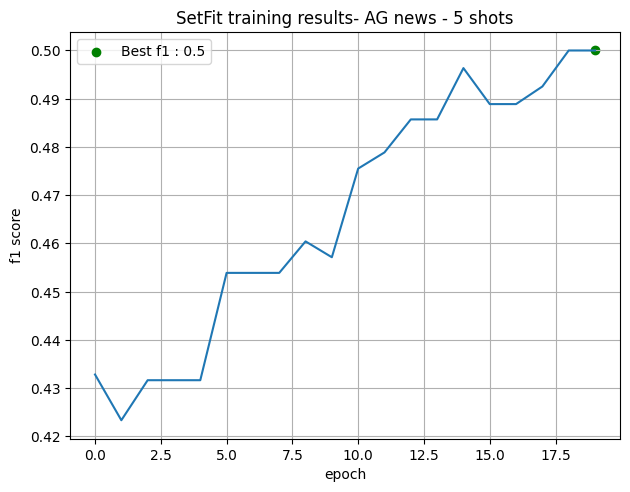

In [141]:
# history = ([k.to('cpu').numpy() for k in history])
plt.plot(history)
plt.scatter(
    [best_epoch], 
    best_f1.item(),
    color = "green",
    label = f"Best f1 : {round(best_f1.item(),3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title("SetFit training results- AG news - 5 shots")

## Inference

In [142]:
y_true_val = torch.tensor([],device=device)
y_pred_val = torch.tensor([],device=device)


for i in tqdm(range(len(test_df['label']))):
    text = test_df['text'][i]
    label = torch.tensor(test_df['label'][i])\
        .to(device)

    with torch.no_grad():
        embedding = embedding_model.encode(text, convert_to_tensor=True)

        y_pred = trainer.best_clf(embedding)\
            .argmax()
        
        y_pred_val = torch.cat([
            y_pred_val, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_val = torch.cat([
            y_true_val, 
            torch.tensor([test_df['label'][i]]).to(device)
        ])
        
f1 = binary_f1_score(
    y_pred_val,
    y_true_val,
    # num_classes=num_classes
)



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:08<00:00, 120.77it/s]


In [143]:
f1

tensor(0.5821, device='cuda:0')